In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('data/final_data.csv')
dataset

,text,labels,id,author,subreddit,created_utc,cluster,topic
0,My favourite food is anything I didn't have to...,27,eebbqej,Rockzilla78,KitchenConfidential,2019-01-18,1,other
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,cocaineluna,morbidquestions,2019-01-01,0,humor
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,minnesotagoat_,timberwolves,2019-01-26,2,sport
3,To make her feel threatened,14,ed7ypvh,AlexNic1013,askwomenadvice,2019-01-04,4,love and relationship
4,Dirty Southern Wankers,3,ed0bdzj,having_a_nap,london,2019-01-01,1,other
...,...,...,...,...,...,...,...,...
54258,Thanks. I was diagnosed with BP 1 after the ho...,15,efeeasc,scaredyk4t,bipolar,2019-01-30,4,love and relationship
54259,Well that makes sense.,4,ef9c7s3,LX_Emergency,ABoringDystopia,2019-01-29,3,politics
54260,Daddy issues [NAME],27,efbiugo,your_ex_girlfriend-,SquaredCircle,2019-01-30,5,film and TV series
54261,So glad I discovered that subreddit a couple m...,0,efbvgp9,Paladin-Arda,AskALiberal,2019-01-30,3,politics


In [3]:
import torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### Train-Validation-Test split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = dataset.drop(columns=['labels'])
y = dataset['labels']

# split train - test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split train - validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42) 

In [7]:
# lenght training set
len(X_train)

39069

In [8]:
# lenght validation set
len(X_val)

4341

In [9]:
# lenght testing set
len(X_test)

10853

### Tokenization

In [10]:
from transformers import AutoTokenizer

/home/biso/Uni/corsi/uni_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
model_name = "monologg/bert-base-cased-goemotions-original"

tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(
    list(X_train['text']),
    truncation=True,
    padding=True,
    return_tensors='pt'
)

val_encodings = tokenizer(
    list(X_val['text']),
    truncation=True,
    padding=True,
    return_tensors='pt' 
)

test_encodings = tokenizer(
    list(X_test['text']),
    truncation=True,
    padding=True,
    return_tensors='pt'
)

In [12]:
idx = 0

# original
print("Original:", X_train.iloc[idx]['text'])

print("-------------------------------------------")

# token_id and mask
print("Token IDs:", train_encodings['input_ids'][idx][:10])
print("Attention Mask:", train_encodings['attention_mask'][idx][:10])

print("-------------------------------------------")

# show tokens
tokens = tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][idx])
print("Tokenizzati:", tokens[:10])

Original: Chicken. Mailman.
-------------------------------------------
Token IDs: tensor([  101, 18770,   119, 11508,  1399,   119,   102,     0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0])
-------------------------------------------
Tokenizzati: ['[CLS]', 'Chicken', '.', 'Mail', '##man', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


### Model

In [13]:
from transformers import AutoModelForSequenceClassification

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [15]:
import json

print(json.dumps(model.config.to_dict(), indent=4))

{
    "return_dict": true,
    "output_hidden_states": false,
    "output_attentions": false,
    "torchscript": false,
    "torch_dtype": "float32",
    "use_bfloat16": false,
    "tf_legacy_loss": false,
    "pruned_heads": {},
    "tie_word_embeddings": true,
    "chunk_size_feed_forward": 0,
    "is_encoder_decoder": false,
    "is_decoder": false,
    "cross_attention_hidden_size": null,
    "add_cross_attention": false,
    "tie_encoder_decoder": false,
    "max_length": 20,
    "min_length": 0,
    "do_sample": false,
    "early_stopping": false,
    "num_beams": 1,
    "num_beam_groups": 1,
    "diversity_penalty": 0.0,
    "temperature": 1.0,
    "top_k": 50,
    "top_p": 1.0,
    "typical_p": 1.0,
    "repetition_penalty": 1.0,
    "length_penalty": 1.0,
    "no_repeat_ngram_size": 0,
    "encoder_no_repeat_ngram_size": 0,
    "bad_words_ids": null,
    "num_return_sequences": 1,
    "output_scores": false,
    "return_dict_in_generate": false,
    "forced_bos_token_id": null

In [16]:
print("Number of labels:", model.config.num_labels)
print("------------------------------------------")
map_labels = model.config.id2label
for idx in sorted(map_labels.keys()):
    print(f"Index {idx} -> {map_labels[idx]}")

Number of labels: 28
------------------------------------------
Index 0 -> admiration
Index 1 -> amusement
Index 2 -> anger
Index 3 -> annoyance
Index 4 -> approval
Index 5 -> caring
Index 6 -> confusion
Index 7 -> curiosity
Index 8 -> desire
Index 9 -> disappointment
Index 10 -> disapproval
Index 11 -> disgust
Index 12 -> embarrassment
Index 13 -> excitement
Index 14 -> fear
Index 15 -> gratitude
Index 16 -> grief
Index 17 -> joy
Index 18 -> love
Index 19 -> nervousness
Index 20 -> optimism
Index 21 -> pride
Index 22 -> realization
Index 23 -> relief
Index 24 -> remorse
Index 25 -> sadness
Index 26 -> surprise
Index 27 -> neutral


### Training

In [35]:
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch 
import os

In [22]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = list(labels) 

    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[index])
        return item

    def __len__(self):
        return len(self.labels)

In [23]:
train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)
test_dataset = EmotionDataset(test_encodings, y_test)

In [26]:
for i in range(3):
    ex = train_dataset[i]
    print(f"\nSample {i}")
    print("Tokens:", tokenizer.convert_ids_to_tokens(ex['input_ids'][:10]))
    print("Label:", ex['labels'].item())


Sample 0
Tokens: ['[CLS]', 'Chicken', '.', 'Mail', '##man', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
Label: 27

Sample 1
Tokens: ['[CLS]', 'This', 'is', 'a', 'hi', '##ge', 'step', '!', 'Con', '##gratulations']
Label: 0

Sample 2
Tokens: ['[CLS]', '>', 'Imagine', 'the', '~', '~', 'nightmare', 'of', 'regulation', '~']
Label: 0


In [34]:
model.to(device)

train_batch_size = 32
val_batch_size = 64
n_epochs = 3
learning_rate = 2e-5

# dataloader
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size)

optimizer = AdamW(model.parameters(), lr=learning_rate)

best_f1 = 0.0
save_path = "./best_model"
os.makedirs(save_path, exist_ok=True)

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    print(f"\n Epoch {epoch+1}/{n_epochs}")

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss/len(train_loader)
    print(f"✅ Training Loss: {avg_train_loss:.4f}")

    # ---validation---
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Validation Accuracy = {accuracy:4f} | F1 score = {f1:4f}")

    if f1 > best_f1:
        best_f1 = f1
        model.save_pretrained(save_path)

tokenizer.save_pretrained(save_path)
print(f"✅ Modello e tokenizer salvati in: {save_path}")


 Epoch 1/3


100%|██████████| 1221/1221 [08:21<00:00,  2.44it/s]


✅ Training Loss: 0.5829
Validation Accuracy = 0.883207 | F1 score = 0.882518

 Epoch 2/3


100%|██████████| 1221/1221 [10:47<00:00,  1.89it/s]  


✅ Training Loss: 0.3619
Validation Accuracy = 0.872610 | F1 score = 0.872843

 Epoch 3/3


100%|██████████| 1221/1221 [07:51<00:00,  2.59it/s]


✅ Training Loss: 0.2225
Validation Accuracy = 0.865238 | F1 score = 0.864789
✅ Modello e tokenizer salvati in: ./best_model


### Testing

In [39]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [37]:
model = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(save_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [38]:
test_batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

# test set results
print("\n Test set results:")
print(f"- Accuracy score = {accuracy:4f}")
print(f"- Precision = {precision:4f}")
print(f"- Recall = {recall:4f}")
print(f"- F1 score = {f1:4f}")

print("\nClassification report:\n")
print(classification_report(all_labels, all_preds))


 Test set results:
- Accuracy score = 0.871280
- Precision = 0.872160
- Recall = 0.871280
- F1 score = 0.870530

Classification report:

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1066
           1       0.92      0.95      0.93       516
           2       0.87      0.85      0.86       405
           3       0.85      0.77      0.81       560
           4       0.87      0.80      0.83       684
           5       0.80      0.77      0.79       233
           6       0.81      0.84      0.82       283
           7       0.82      0.88      0.85       423
           8       0.91      0.73      0.81       144
           9       0.81      0.77      0.79       260
          10       0.84      0.79      0.82       432
          11       0.75      0.88      0.81       152
          12       0.86      0.90      0.88        63
          13       0.72      0.86      0.79       155
          14       0.84      0.86      0.85       1

In [41]:
print(model.config.id2label)

{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


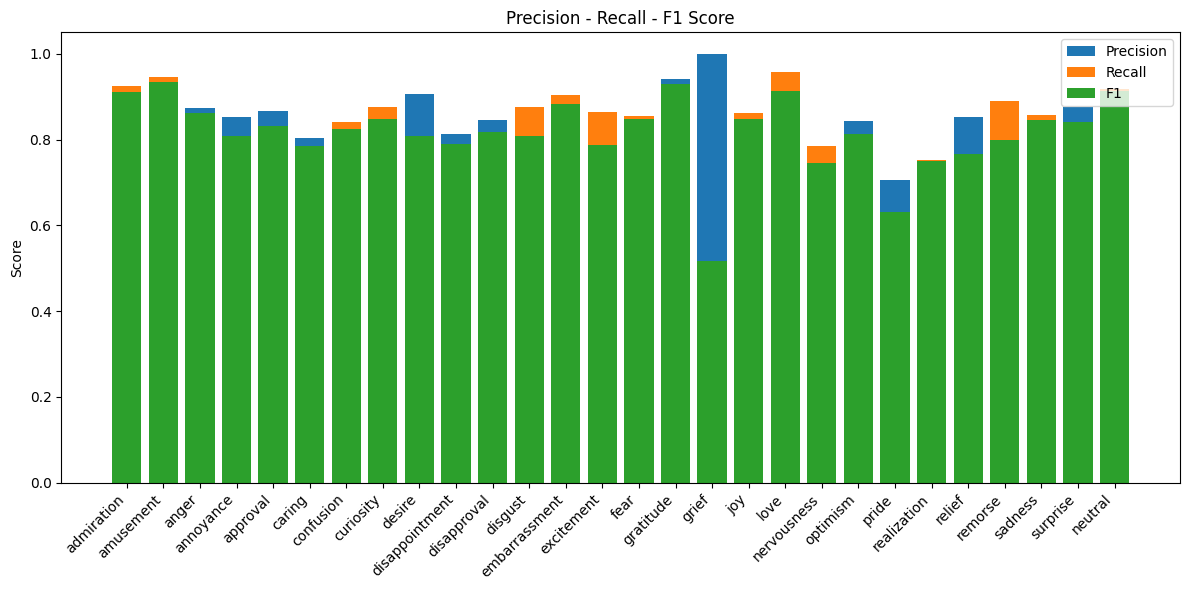

In [47]:
precisions, recalls, f1s, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

id2label = model.config.id2label
labels = [id2label[i] for i in range(len(precisions))]

df_metrics = pd.DataFrame({
    'label': labels,
    'precision': precisions,
    'recall': recalls,
    'f1': f1s
})

plt.figure(figsize=(12, 6))
x = range(len(df_metrics))

plt.bar(x, df_metrics["precision"], label="Precision")
plt.bar(x, df_metrics["recall"], label="Recall")
plt.bar(x, df_metrics["f1"], label="F1")

plt.xticks(x, df_metrics["label"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Precision - Recall - F1 Score")
plt.legend()
plt.tight_layout()
plt.show()